> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Investigation of Kaggle's soccer database
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sqla
import xml.etree.ElementTree as ET
%matplotlib inline
#plt.style.use('fivethirtyeight')


<a id='wrangling'></a>
## Data Wrangling

> **Load data**: loading 2 data frames from the sql database. 
In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [220]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
# build sql query to extract match data - ignore data without valid possession data
query_match = """
select match.id as match_id, league.name, season, possession, home_team.Team_long_name, away_team.Team_long_name, home_team_api_id,away_team_api_id, home_team_goal, away_team_goal, shoton, shotoff, goal
from Match inner join league on match.league_id = league.id
inner join team as home_team on home_team.team_api_id = match.home_team_api_id
inner join team as away_team on away_team.team_api_id = match.away_team_api_id
where possession is  not null and possession <> '<possession />' and goal is not null and shoton is not null and shotoff is not null;
 """
query_player = """
select player_api_id, player_name from player;
 """
db = sqla.create_engine('sqlite:///data/database.sqlite')
df_match = pd.read_sql(query_match, db)
df_player = pd.read_sql(query_player,db)
print(df_match.iloc[:3,:10])
print(df_player.head())
print(df_match.dtypes)
print(df_player.dtypes)
df_match.shape

   match_id                    name     season  \
0      1729  England Premier League  2008/2009   
1      1730  England Premier League  2008/2009   
2      1731  England Premier League  2008/2009   

                                          possession     team_long_name  \
0  <possession><value><comment>56</comment><event...  Manchester United   
1  <possession><value><comment>65</comment><event...            Arsenal   
2  <possession><value><comment>45</comment><event...         Sunderland   

         team_long_name  home_team_api_id  away_team_api_id  home_team_goal  \
0      Newcastle United             10260             10261               1   
1  West Bromwich Albion              9825              8659               1   
2             Liverpool              8472              8650               0   

   away_team_goal  
0               1  
1               0  
2               1  
   player_api_id         player_name
0         505942  Aaron Appindangoye
1         155782     Aaron 

(8419, 13)

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning
First defining some helper functions, see the comments in the line above the definition to learn about their specific tasks
```
def flatten(list_of_list)

def build_possession_row_from_xml(xmlstring, matchid)

def build_shotlists_from_xml(xmlstring, matchid)
```



In [148]:
# Helper function flatten, flattening of lists. occassionally we have to deal with lists of lists
#which have to be flattened to be used in data frames.
def flatten(list_of_list):
    flattened_list = [y for x in list_of_list for y in x]
    return flattened_list

# Helper function to extract xml data from the column possession of data frame df_match
def build_possession_row_from_xml(xmlstring, matchid):
    root = ET.fromstring(xmlstring)
    # we are interested in the last entry only, usually the possession values after 90 minutes
    tags = root.findall("value[last()]")

    rows = []
    #there should be only one tag found, but leaving loop for possible later changes
    for node in tags:
        #print(node)
        elapsed = node.findtext("elapsed") if node is not None else None
        homepos = node.findtext("homepos") if node is not None else None
        
        awaypos = node.findtext("awaypos") if node is not None else None
        rows.append({"match_id": matchid, "elapsed": elapsed, "homepos": homepos, 
                     "awaypos": awaypos})
    if rows.count == 0:
        return  None
    else:
        #return value is a list of dictionaries
        return rows

# Helper function to extract xml data from the columns shoton,shotoff and goals of df_match
def build_shotlists_from_xml(xmlstring, matchid):
    root = ET.fromstring(xmlstring)
   
    rows = []
    for node in root: 
        elapsed = node.findtext("elapsed") if node is not None else None
        team = node.findtext("team") if node is not None else None
        type_s = node.findtext("type") if node is not None else None
        player = node.findtext("player1") if node is not None else None
        subtype = node.findtext('subtype') if node is not None else None
        goalno = node.findtext('stats/goal') if node is not None else None
        shotonno = node.findtext('stats/shoton') if node is not None else None
        shotoffno = node.findtext('stats/shotoff') if node is not None else None
        
        rows.append({"match_id": matchid, "elapsed": elapsed, "team": team, "player": player, "subtype" : subtype,
                     "type": type_s, 'goal_no' : goalno, 'shoton_no' : shotonno, 'shotoff_no' : shotoffno, 'shotcnt': 1})
    if rows.count == 0:
        return  None
    else:
        return rows

> **create additional data frames**  
Creating some extra data frames from xml content of some columns of the `df_match` data frame with the code of next cells.  
These data frames are needed later for further analysis.

#### Create data frame `df_pos` for possession data

In [156]:
# parse xml data of column possession with helper funcion
rows_pos = df_match.apply(lambda x : build_possession_row_from_xml(x['possession'], x['match_id']), axis=1)
flattened_list = flatten(rows_pos.values.tolist())
print(len(flattened_list))
# build new data frame with possession data and show a few lines and data types
df_pos = pd.DataFrame(flattened_list)
print(df_pos.loc[:3])
print(df_pos.dtypes)
# show possible NaN values
print(df_pos.isna().sum())
df_pos.shape

8419
   match_id elapsed homepos awaypos
0      1729      90      55      45
1      1730      90      66      34
2      1731      90      46      54
3      1732      90      52      48
match_id     int64
elapsed     object
homepos     object
awaypos     object
dtype: object
match_id    0
elapsed     0
homepos     2
awaypos     2
dtype: int64


(8419, 4)

##### comment
> 3 columns of new data frame `df_pos` are all strings because of the previous xml parsing.  
So, casting columns to ints. *homepos, awaypos* both have NaNs in certain rows. We have to drop affected rows first.



In [157]:
# get rid of rows with NaNs in homepos or awaypos
df_pos.dropna(subset=['homepos','awaypos'], inplace=True)
# set all columns to int64 and check with dtype
df_pos = df_pos.astype('int64')
df_pos.dtypes



match_id    int64
elapsed     int64
homepos     int64
awaypos     int64
dtype: object

#### Create data frame `df_shots` from shotson, shotsoff and goal data

In [165]:
rows_on = df_match.apply(lambda x : build_shotlists_from_xml(x['shoton'], x['match_id']), axis=1)
df_shoton = pd.DataFrame(flatten(rows_on.values.tolist()))
rows_off = df_match.apply(lambda x : build_shotlists_from_xml(x['shotoff'], x['match_id']), axis=1)
df_shotoff = pd.DataFrame(flatten(rows_off.values.tolist()))
rows_goals = df_match.apply(lambda x : build_shotlists_from_xml(x['goal'], x['match_id']), axis=1)
df_goal = pd.DataFrame(flatten(rows_goals.values.tolist()))
df_shots = pd.concat([df_shotoff, df_shoton, df_goal])
#df_shots[df_shots['match_id']==1729].sort_values(by=['elapsed'])
df_shots['player'] = pd.to_numeric(df_shots['player'], errors='coerce')
df_shots['team'] = pd.to_numeric(df_shots['team'],  errors='coerce')

#df_shots['player'] = df_shots[df_shots['player'].notnull()]['player'].astype('int64')
df_shots.reset_index()
df_shots.head()
df_shots.dtypes

match_id        int64
elapsed        object
team          float64
player        float64
subtype        object
type           object
goal_no        object
shoton_no      object
shotoff_no     object
shotcnt         int64
dtype: object

In [153]:
result = df_player.merge(df_shots, left_on=('player_api_id'), right_on=('player'))
result.groupby('player_name')

,match_id,elapsed,team,player,type
0,1729,22,10261,37799,goal
1,1729,24,10260,24148,goal
2,1730,4,9825,26181,goal
3,1731,83,8650,30853,goal
4,1732,4,8654,23139,goal
...,...,...,...,...,...
8629,4765,56,10194,110148,goal
8630,4767,62,9825,50047,goal
8631,4767,68,9825,46469,goal
8632,4767,74,9825,75489,goal


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1: What is the correlation between ball possession and goal differences in a match?

In [182]:
# Use this, and more code cells, to explore your data. Don't forget to add
df_match_wp = df_pos.merge(df_match, on='match_id')
# drop unnecessary columns with xml data:
df_match_wp.drop(['possession', 'shoton', 'shotoff', 'goal'], axis=1, inplace=True)
#create additional column 'goal difference'
df_match_wp['goaldiff'] = df_match_wp['home_team_goal'] - df_match_wp['away_team_goal']
df_match_wp['homepos'].mean()

tmpdf = df_shots.groupby(['match_id', 'team'], as_index=False)['shotcnt'].sum()
tmpdf
df_match_wp = df_match_wp.merge(tmpdf, left_on=['match_id','home_team_api_id'], right_on=['match_id', 'team'])
df_match_wp = df_match_wp.merge(tmpdf, left_on=['match_id','away_team_api_id'], right_on=['match_id', 'team'])
# rename new columns:
df_match_wp.rename(columns={"shotcnt_x": "home_team_shots", "shotcnt_y": "away_team_shots"}, inplace=True)
# drop redundant columns with team no
df_match_wp.drop(['team_y','team_x'], axis=1, inplace=True)
df_match_wp['shotdiff'] = df_match_wp['home_team_shots'] - df_match_wp['away_team_shots']
df_match_wp.head()

,match_id,elapsed,homepos,awaypos,name,season,team_long_name,team_long_name,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goaldiff,home_team_shots,away_team_shots,shotdiff
0,1729,90,55,45,England Premier League,2008/2009,Manchester United,Newcastle United,10260,10261,1,1,0,22,11,11
1,1730,90,66,34,England Premier League,2008/2009,Arsenal,West Bromwich Albion,9825,8659,1,0,1,26,5,21
2,1731,90,46,54,England Premier League,2008/2009,Sunderland,Liverpool,8472,8650,0,1,-1,7,17,-10
3,1732,90,52,48,England Premier League,2008/2009,West Ham United,Wigan Athletic,8654,8528,2,1,1,14,23,-9
4,1733,90,52,48,England Premier League,2008/2009,Aston Villa,Manchester City,10252,8456,4,2,2,13,16,-3


Text(0.5, 1.0, 'hallo')

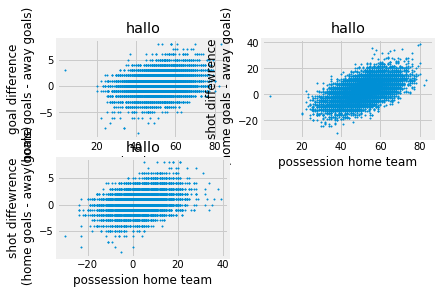

In [186]:
# visualization
plt.figure()
#plt.tight_layout()
plt.subplot(221)
plt.scatter(df_match_wp['homepos'], df_match_wp['goaldiff'], s=2)
plt.xlabel('possession home team')
plt.ylabel('goal difference\n (home goals - away goals)')
plt.title('hallo')

plt.subplot(222)
plt.scatter(df_match_wp['homepos'], df_match_wp['shotdiff'], s=2)
plt.xlabel('possession home team')
plt.ylabel('shot diffewrence\n (home goals - away goals)')
plt.title('hallo')

plt.subplot(223)
plt.scatter(df_match_wp['shotdiff'], df_match_wp['goaldiff'], s=2)
plt.xlabel('possession home team')
plt.ylabel('shot diffewrence\n (home goals - away goals)')
plt.title('hallo')

### Research Question 2  (Replace this header name!)

In [236]:
df_match_shots = df_match.merge(df_shots, on='match_id')
# possession, shoton, shotoff, goals not needed in df_match_shots:
df_match_shots.drop(['possession', 'shoton', 'shotoff', 'goal'], axis=1, inplace=True)
df_match_shots[(df_match_shots['type'] == 'goal') & (df_match_shots['subtype'].isin(['saved', 'missed', 'crossbar', 'post','saved_back_into_play', 'saved']))]
# there are some subtypes of type goal which actually aren't goals:
no_goals_list = ['saved', 'missed', 'crossbar', 'post','saved_back_into_play', 'saved']
#df_match_shots[(df_match_shots['type'] == 'goal')]['subtype'].value_counts()
#create new column goalQ - True if shot was a goal, False if not
df_match_shots['goalQ'] = (df_match_shots['type'] == 'goal') & (~df_match_shots['subtype'].isin(no_goals_list))
df_player_shots = df_match_shots.groupby(['player', 'goalQ'])['shotcnt'].sum().reset_index()
df_player_shots
df_player_plus = None
df_player_plus = df_player.merge(df_player_shots[df_player_shots['goalQ']==True], left_on='player_api_id', right_on='player')
df_player_plus = df_player_plus.merge(df_player_shots[df_player_shots['goalQ']==False], left_on='player_api_id', right_on='player')
df_player_plus.drop(['player_x', 'goalQ_x', 'player_y', 'goalQ_y'], axis=1, inplace=True)
df_player_plus.rename(columns={"shotcnt_x":"goals", "shotcnt_y":"shots_missed"}, inplace=True)
df_player_plus['conversion rate'] = df_player_plus['goals'] / (df_player_plus['goals'] + df_player_plus['shots_missed'])
df_player_plus.sort_values(by='conversion rate', ascending=False)
df_player_plus[df_player_plus['goals']>50].sort_values(by='conversion rate', ascending=False)



,player_api_id,player_name,goals,shots_missed,conversion rate
1398,70409,Javier Hernandez,63,211,0.229927
1167,25759,Gonzalo Higuain,137,461,0.229097
1824,30981,Lionel Messi,216,747,0.224299
1998,27326,Mario Gomez,61,216,0.220217
1677,26166,Karim Benzema,87,336,0.205674
854,49677,Edinson Cavani,86,343,0.200466
3235,35724,Zlatan Ibrahimovic,144,576,0.200000
1743,36784,Klaas Jan Huntelaar,56,228,0.197183
687,23949,Darren Bent,70,294,0.192308
306,33028,Aritz Aduriz,62,269,0.187311


In [225]:
df_match_shots.groupby(['match_id','home_team_goal', 'away_team_goal', 'team', 'type']).size()

match_id  home_team_goal  away_team_goal  team     type   
1729      1               1               10260.0  goal        1
                                                   shotoff    10
                                                   shoton     11
                                          10261.0  goal        1
                                                   shotoff     9
                                                              ..
24557     3               0               8370.0   shotoff     3
                                                   shoton      8
                                          8558.0   goal        1
                                                   shotoff     3
                                                   shoton      3
Length: 45606, dtype: int64

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!